In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))
일별_강서_데이터= 강서_데이터.groupby('기준_날짜')['전체_건수'].sum()

기상청_데이터 = pd. read_csv('../../Data/기상청/기온강수량미세먼지2.csv',encoding='utf-8')
기상청_데이터.fillna(0, inplace=True)

3385613


In [16]:
휴일 = [
    {"날짜": "2023-05-05"},
    {"날짜": "2023-05-29"},
    {"날짜": "2023-06-06"},
    {"날짜": "2023-08-15"},
    {"날짜": "2023-09-28"},
    {"날짜": "2023-09-29"},
    {"날짜": "2023-10-02"},
    {"날짜": "2023-10-03"},
    {"날짜": "2023-10-09"},
    {"날짜": "2023-12-25"},
    {"날짜": "2024-01-01"},
    {"날짜": "2024-02-09"},
    {"날짜": "2024-02-12"},
    {"날짜": "2024-03-01"},
]
# 주말과 휴일을 분류하는 함수 정의
def classify_weekend_and_holidays(df, holidays):
    # '일시' 열을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 주말(토요일: 5, 일요일: 6)인지 여부를 나타내는 열 추가
    df['요일'] = df['일시'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일
    df['주말'] = df['요일'].apply(lambda x: 1 if x >= 5 else 0)  # 토요일(5) 또는 일요일(6)이면 주말로 분류
    
    # 휴일인지 여부를 나타내는 열 추가
    df['휴일'] = df['일시'].apply(lambda x: 1 if str(x.date()) in [h['날짜'] for h in holidays] else 0)
    
    # 주말과 휴일으로 데이터 분리
    주말_df = df[(df['주말'] == 1) | (df['휴일'] == 1)]
    주중_df = df[(df['주말'] == 0) & (df['휴일'] == 0)]
    
    return 주말_df, 주중_df

In [17]:

# Series를 DataFrame으로 변환
일별_강서_데이터 = pd.DataFrame(일별_강서_데이터.items(), columns=['기준_날짜', '전체_건수'])

# 기상청_주중,주말데이터 구분
기상청_주말_데이터, 기상청_주중_데이터 = classify_weekend_and_holidays(기상청_데이터, 휴일)

기상청_주중_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)

# 기상청_주중_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])

# 일별_강서_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
일별_강서_데이터['기준_날짜'] = pd.to_datetime(일별_강서_데이터['기준_날짜'])

# 두 데이터프레임의 '기준_날짜' 값을 비교하여 있는 값과 없는 값을 구분
공통_날짜 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')['기준_날짜']
기상청_누락_날짜 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']
강서_누락_날짜 = 일별_강서_데이터[~일별_강서_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']


기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]

C:\Users\ciw96\AppData\Local\Temp\ipykernel_29288\2836046250.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_주중_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)
C:\Users\ciw96\AppData\Local\Temp\ipykernel_29288\2836046250.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])


In [20]:

# 기상청 데이터와 일별 데이터를 기준_날짜를 기준으로 병합
기상청_분석 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')

# 상관관계 계산
correlation_micron = 기상청_분석['미세먼지'].corr(기상청_분석['전체_건수'])
correlation_micron2 = 기상청_분석['초미세먼지'].corr(기상청_분석['전체_건수'])
correlation_rainfall = 기상청_분석['일강수량(mm)'].corr(기상청_분석['전체_건수'])
correlation_temperature = 기상청_분석['평균기온(°C)'].corr(기상청_분석['전체_건수'])
correlation_all = 기상청_분석[['미세먼지','초미세먼지', '일강수량(mm)', '평균기온(°C)','전체_건수']].corr()['전체_건수']

# 상관관계 출력
print("미세먼지와 전체_건수의 상관관계:", correlation_micron)
print("초미세먼지와 전체_건수의 상관관계:", correlation_micron2)
print("강수량과 전체_건수의 상관관계:", correlation_rainfall)
print("평균기온과 전체_건수의 상관관계:", correlation_temperature)
print("위 3가지와 전체_건수의 상관관계:")
print(correlation_all)

미세먼지와 전체_건수의 상관관계: 0.06285749066215539
초미세먼지와 전체_건수의 상관관계: 0.040195739036415955
강수량과 전체_건수의 상관관계: -0.4911054970043694
평균기온과 전체_건수의 상관관계: 0.6030319747813816
위 3가지와 전체_건수의 상관관계:
미세먼지        0.062857
초미세먼지       0.040196
일강수량(mm)   -0.491105
평균기온(°C)    0.603032
전체_건수       1.000000
Name: 전체_건수, dtype: float64


In [ ]:
selected_columns = ['기준_날짜', '미세먼지', '초미세먼지', '평균기온(°C)', '일강수량(mm)', '전체_건수']
기상청_분석 = 기상청_분석[selected_columns ]
기상청_분석 = 기상청_분석.rename(columns={'평균기온(°C)': '평균기온', '일강수량(mm)': '일강수량'})
기상청_분석

In [29]:
# 독립 변수(X): 평균기온
X = 기상청_분석['평균기온']

# 종속 변수(Y): 전체_건수
Y = 기상청_분석['전체_건수']

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀 모델 적합
model = sm.OLS(Y, X)

# 적합된 모델 피팅
results = model.fit()

# 회귀 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     148.6
Date:                Tue, 07 May 2024   Prob (F-statistic):           2.46e-27
Time:                        15:33:49   Log-Likelihood:                -2564.1
No. Observations:                 262   AIC:                             5132.
Df Residuals:                     260   BIC:                             5139.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.054e+04    471.889     22.341      0.0

In [26]:
# 4~10 월 데이터 추출
특정달_기상청_분석 = 기상청_분석[(기상청_분석['기준_날짜'] >= '2023-04-01') & (기상청_분석['기준_날짜'] <= '2023-10-31')]

# 일강수량과 전체 건수 간의 상관관계 분석
correlation = 특정달_기상청_분석['일강수량'].corr(특정달_기상청_분석['전체_건수'])
print(correlation)

-0.7754638839621482


In [28]:
import statsmodels.api as sm

# 회귀 분석을 위한 데이터셋 준비
기상청_분석.dropna(inplace=True)  # 결측치가 있는 행 제거
X = 기상청_분석[['일강수량', '평균기온']]
y = 기상청_분석['전체_건수']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     344.0
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.23e-73
Time:                        15:33:40   Log-Likelihood:                -2453.5
No. Observations:                 262   AIC:                             4913.
Df Residuals:                     259   BIC:                             4924.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.081e+04    310.314     34.842      0.0

In [30]:
results_list = []

# 0°C부터 30°C까지의 기온에 대해 예상 자전거 이용량 계산
for temperature in range(0, 31):
    predicted_bike_count = results.params['const'] + results.params['평균기온'] * temperature
    results_list.append({'기온(°C)': temperature, '예상 자전거 이용량': predicted_bike_count})

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results_list)

print(results_df)

    기온(°C)    예상 자전거 이용량
0        0  10542.452882
1        1  10862.368773
2        2  11182.284663
3        3  11502.200554
4        4  11822.116445
5        5  12142.032336
6        6  12461.948226
7        7  12781.864117
8        8  13101.780008
9        9  13421.695899
10      10  13741.611789
11      11  14061.527680
12      12  14381.443571
13      13  14701.359462
14      14  15021.275353
15      15  15341.191243
16      16  15661.107134
17      17  15981.023025
18      18  16300.938916
19      19  16620.854806
20      20  16940.770697
21      21  17260.686588
22      22  17580.602479
23      23  17900.518369
24      24  18220.434260
25      25  18540.350151
26      26  18860.266042
27      27  19180.181932
28      28  19500.097823
29      29  19820.013714
30      30  20139.929605


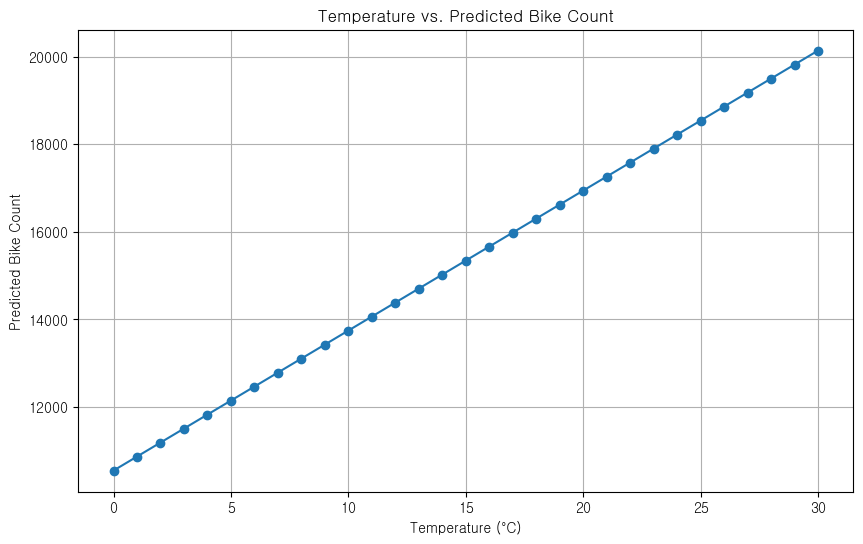

In [31]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 예상 자전거 이용량 데이터 시각화
plt.plot(results_df['기온(°C)'], results_df['예상 자전거 이용량'], marker='o', linestyle='-')

# 그래프 제목과 축 레이블 설정
plt.title('Temperature vs. Predicted Bike Count')
plt.xlabel('Temperature (°C)')
plt.ylabel('Predicted Bike Count')

# 그리드 추가
plt.grid(True)

# 그래프 표시
plt.show()

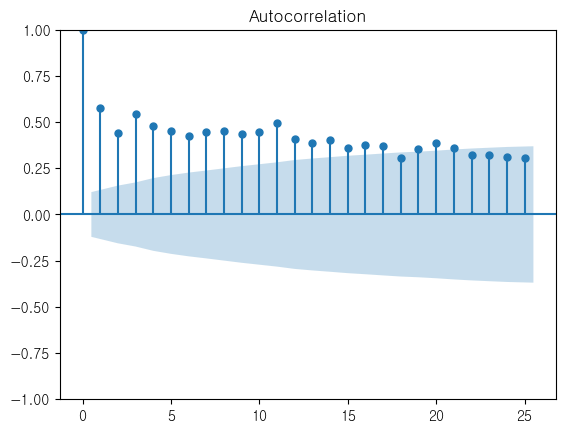

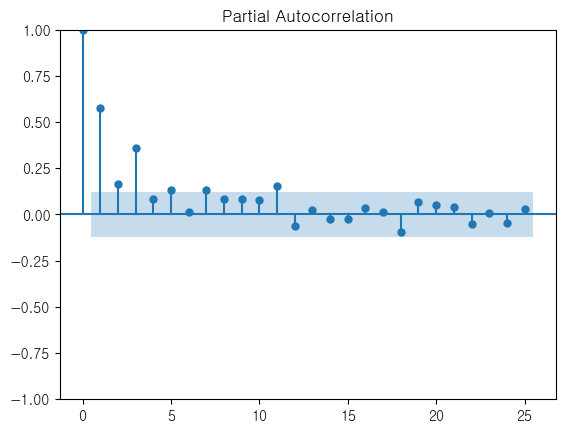

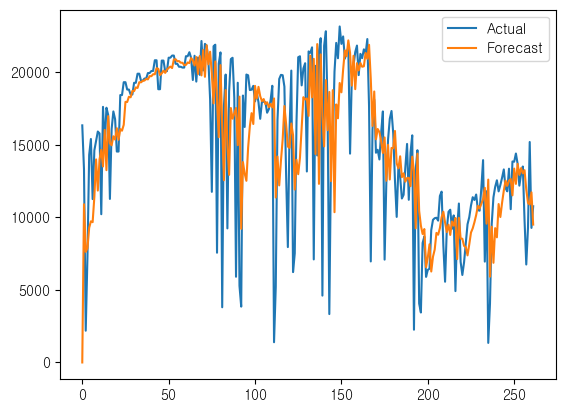

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(기상청_분석['전체_건수'])
plot_pacf(기상청_분석['전체_건수'])
plt.show()

model = ARIMA(기상청_분석['전체_건수'], order=(6, 1, 0))  # p, d, q는 선택한 파라미터입니다.
results = model.fit()

forecast = results.predict(start=0, end=len(기상청_분석)-1, typ='levels')

plt.plot(기상청_분석['전체_건수'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

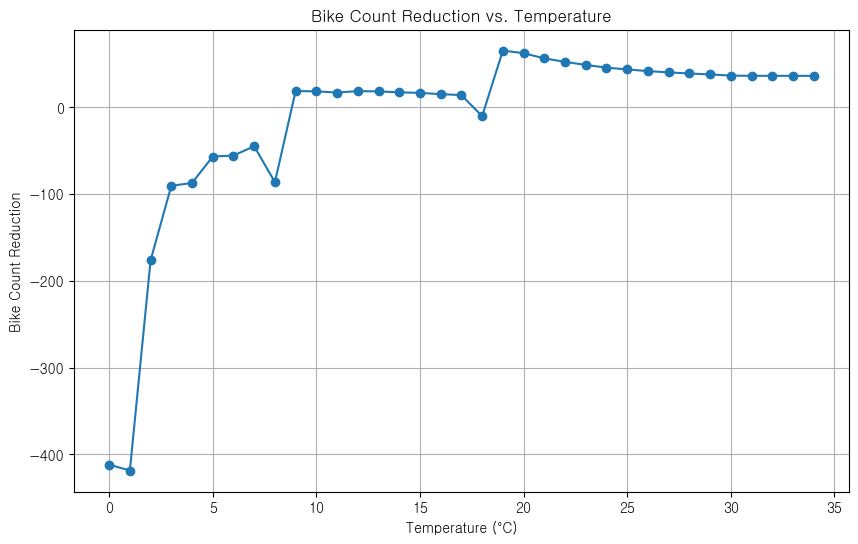

    기온(°C)      이용량_감소
0        0 -411.981319
1        1 -418.818272
2        2 -176.383647
3        3  -90.405349
4        4  -87.108760
5        5  -56.639693
6        6  -55.449891
7        7  -44.815665
8        8  -86.165736
9        9   18.953949
10      10   18.523177
11      11   17.158312
12      12   18.816631
13      13   18.447677
14      14   17.422806
15      15   16.800563
16      16   15.298074
17      17   14.255023
18      18  -10.100742
19      19   65.580542
20      20   62.560385
21      21   56.602253
22      22   52.536898
23      23   49.016384
24      24   45.938061
25      25   43.821099
26      26   41.890655
27      27   40.464590
28      28   39.132422
29      29   38.036714
30      30   36.714975
31      31   36.433634
32      32   36.433634
33      33   36.433634
34      34   36.433634


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델을 학습하기 위한 시계열 데이터 준비
시계열_데이터 = 기상청_분석[['평균기온', '전체_건수']]

# ARIMA 모델 학습
model = ARIMA(시계열_데이터['전체_건수'], order=(6,1,0)) # ARIMA 모델 생성
model_fit = model.fit() # 모델 학습

# 결과를 저장할 빈 리스트 생성
결과 = []

# 0°C부터 30°C까지의 기온 범위에 대해 반복문 실행
for 기온 in range(35):
    # 예측 결과에서 특정 기온 범위 내의 이용량 감소 확인
    특정_기온_범위_이용량 = model_fit.predict(start=0, end=len(기상청_분석)-1)
    특정_기온_범위_이용량 = 특정_기온_범위_이용량[기상청_분석['평균기온'] <= 기온]
    이용량_감소 = 특정_기온_범위_이용량.diff().dropna()
    
    # 결과를 딕셔너리 형태로 저장
    결과.append({
        '기온(°C)': 기온,
        '이용량_감소': 이용량_감소.mean() if len(이용량_감소) > 0 else 0
    })

# 결과를 DataFrame으로 변환
결과_df = pd.DataFrame(결과)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(결과_df['기온(°C)'], 결과_df['이용량_감소'], marker='o', linestyle='-')
plt.title('Bike Count Reduction vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Count Reduction')
plt.grid(True)
plt.show()

# 결과 출력
print(결과_df)
결과_df.to_csv('check1.csv',index=False)

기온과 이용량 간의 상관관계: 0.6030319747813816


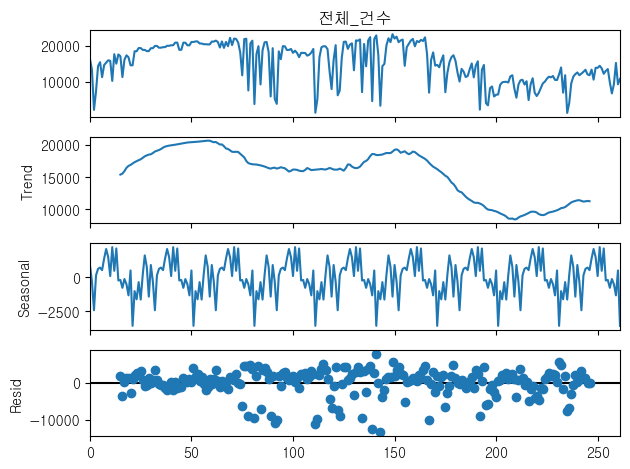

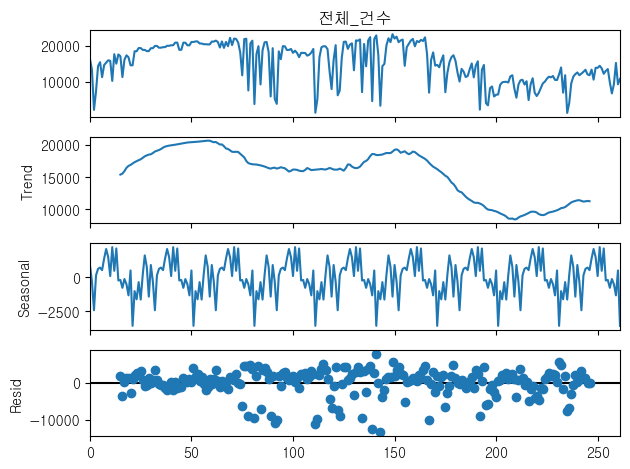

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# 기준_날짜를 날짜형식으로 변환
기상청_분석['기준_날짜'] = pd.to_datetime(기상청_분석['기준_날짜'])

# 기온과 이용량 간의 상관관계 분석
correlation_temperature = 기상청_분석['평균기온'].corr(기상청_분석['전체_건수'])
print("기온과 이용량 간의 상관관계:", correlation_temperature)

# 시계열 분해를 통한 데이터 탐색
result = seasonal_decompose(기상청_분석['전체_건수'], model='additive', period=30)
result.plot()
plt.show()

# 이상치 처리
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

기상청_분석 = remove_outliers(기상청_분석, '전체_건수')

# 이상치 처리 후 시계열 분해 재시도
result_filtered = seasonal_decompose(기상청_분석['전체_건수'], model='additive', period=30)
result_filtered.plot()
plt.show()